#Implémentation du Psi-score

In [1]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import cvxpy as cp


In [2]:
print("Solveurs disponibles :", cp.installed_solvers())

Solveurs disponibles : ['CLARABEL', 'ECOS', 'ECOS_BB', 'MOSEK', 'OSQP', 'SCIPY', 'SCS']


##Paramètres
On commence par générer un **Graphe G=(V,E)** dont la matrice d'adjacence est notée **F**.

In [3]:
n=10 #nombre de noeuds
p=0.4 #probabilité de création d'une arrête
G = nx.erdos_renyi_graph(n,p, seed = 91,directed=True)
F = nx.to_numpy_array(G, dtype=int)
#F est la matrice d'adjacence du graphe G
print(F)


[[0 1 1 0 1 0 0 0 0 0]
 [1 0 0 1 0 0 1 0 0 1]
 [0 0 0 0 1 0 0 1 0 0]
 [0 0 0 0 1 1 1 0 0 1]
 [1 1 0 1 0 1 1 1 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0 1 0 1]
 [0 0 0 1 0 0 0 0 0 1]
 [0 0 1 0 0 1 0 1 0 1]
 [1 0 0 1 0 0 0 1 0 0]]


###Visualisation du Graphe

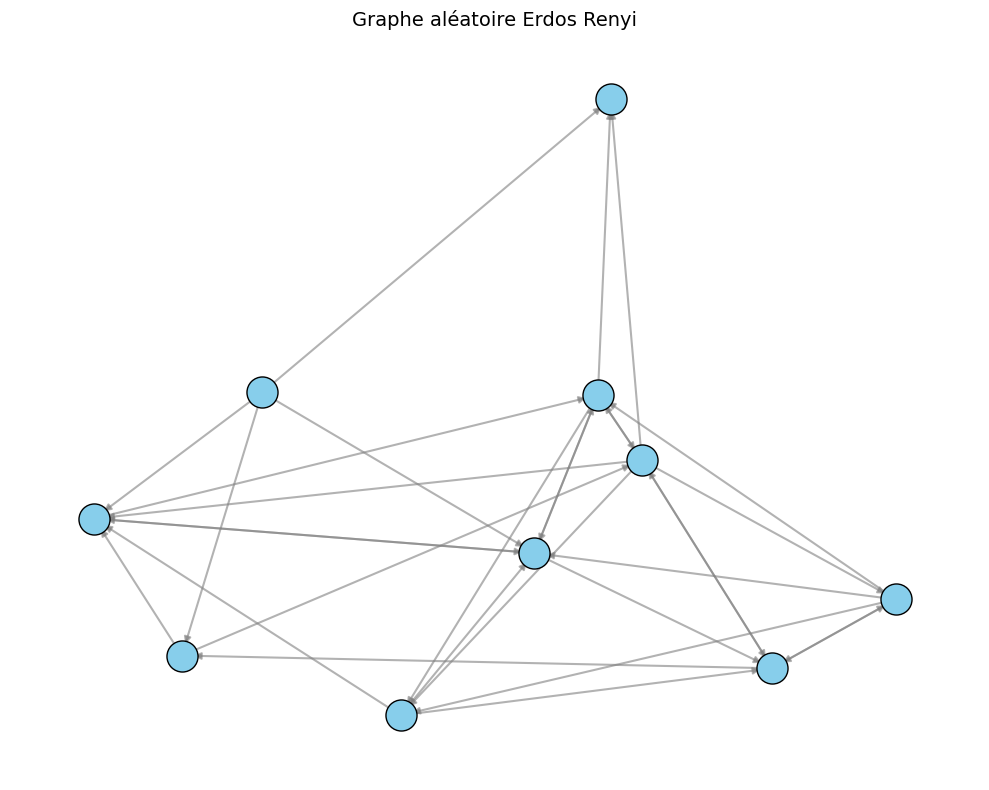

In [4]:
plt.figure(figsize=(10, 8))
pos = nx.spring_layout(G, seed=42)
nx.draw_networkx_nodes(
    G,
    pos,
    node_size=500,
    node_color="skyblue",
    edgecolors="black",
    linewidths=1
)
nx.draw_networkx_edges(
    G,
    pos,
    width=1.5,
    edge_color="gray",
    alpha=0.6
)
plt.title("Graphe aléatoire Erdos Renyi", fontsize=14)
plt.axis("off")  # Désactive les axes
plt.tight_layout()

##Taux
On génére également les **taux  λ(n) et μ(n)** désignant respectivement le taux auquel l'utilisateur n génère de nouvelles publications sur son mur et le taux auquel l'utilisateur n consulte son fil d'actualités et sélectionne l'une des M entrées pour la republier sur son mur.

In [5]:
lambdas = np.random.random(n)
mus = np.random.random(n)

In [6]:
print(lambdas)
print(mus)

[0.5634723  0.41322943 0.19481244 0.63369761 0.48278988 0.31762289
 0.32194178 0.5953885  0.26116834 0.95948857]
[0.1695756  0.63180797 0.45837862 0.58233116 0.34753256 0.40151241
 0.90778055 0.33119861 0.53039293 0.10988613]


In [7]:
value_dict = {i: {'lambda': lambdas[i], 'mu': mus[i]} for i in range(n)}
nx.set_node_attributes(G,value_dict)

In [8]:
def visualiser_graphe(G, titre="Graphe", taille_fig=(10, 8), couleur_noeuds="skyblue",
                     couleur_aretes="gray", taille_noeuds=500, graphe_aleatoire=True, seed=42):
    """
    Visualise un graphe NetworkX avec les attributs 'lambda' et 'mu' des arêtes.

    Paramètres:
        G (nx.Graph): Le graphe à visualiser.
        titre (str): Titre du graphe.
        taille_fig (tuple): Taille de la figure (largeur, hauteur).
        couleur_noeuds (str): Couleur des nœuds.
        couleur_aretes (str): Couleur des arêtes.
        taille_noeuds (int): Taille des nœuds.
        graphe_aleatoire (bool): Si True, utilise un layout aléatoire reproductible.
        seed (int): Graine pour la reproductibilité.
    """
    plt.figure(figsize=taille_fig)

    # Positionnement des nœuds
    pos = nx.spring_layout(G, seed=seed) if graphe_aleatoire else nx.circular_layout(G)

    # Dessin des nœuds
    nx.draw_networkx_nodes(
        G, pos,
        node_size=taille_noeuds,
        node_color=couleur_noeuds,
        edgecolors="black",
        linewidths=1
    )

    # Dessin des arêtes
    nx.draw_networkx_edges(
        G, pos,
        width=1.5,
        edge_color=couleur_aretes,
        alpha=0.6
    )
    labels = {n: f"λ: {G.nodes[n]['lambda']:.2f}\nμ: {G.nodes[n]['mu']:.2f}" for n in G.nodes}

    nx.draw_networkx_labels(G, pos, font_size=10, labels=labels )

    plt.title(titre, fontsize=14)
    plt.axis("off")
    plt.tight_layout()
    plt.show()

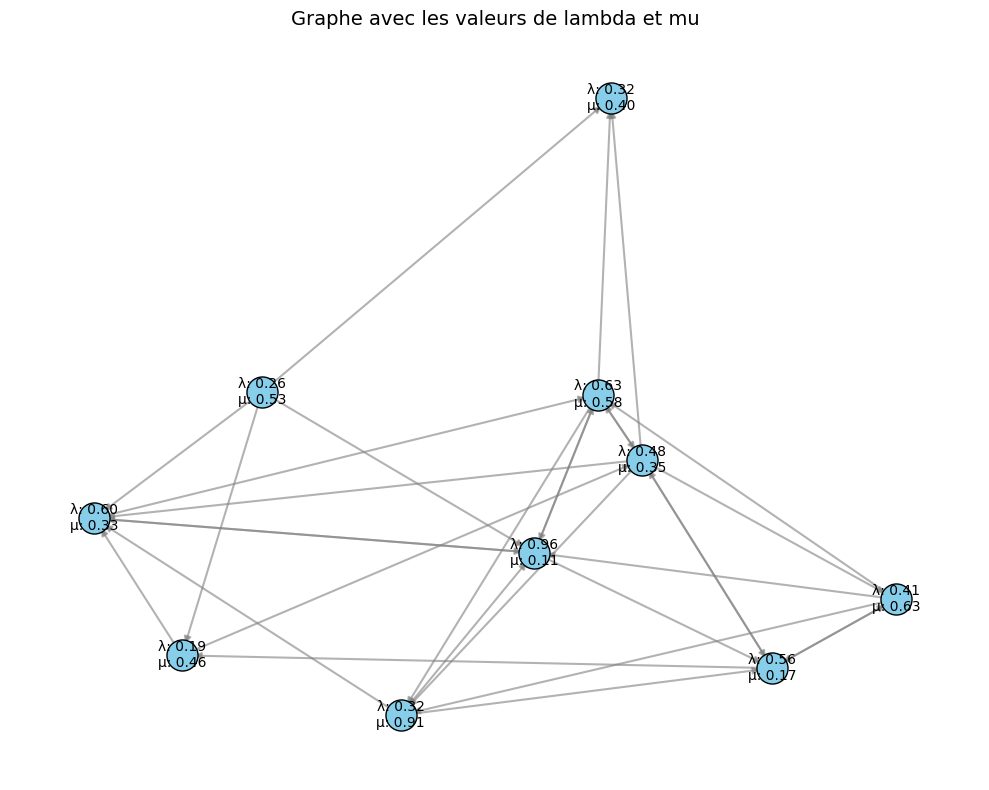

In [9]:
visualiser_graphe(G,titre="Graphe avec les valeurs de lambda et mu")

##Matrice de Propagation
Ensuite, nous allons calculer la **matrice de propagation A** ainsi que les vecteurs ${b_i}$ , la matrice C et les vecteurs ${d_i}$  à l'aide des formules ci-dessous.

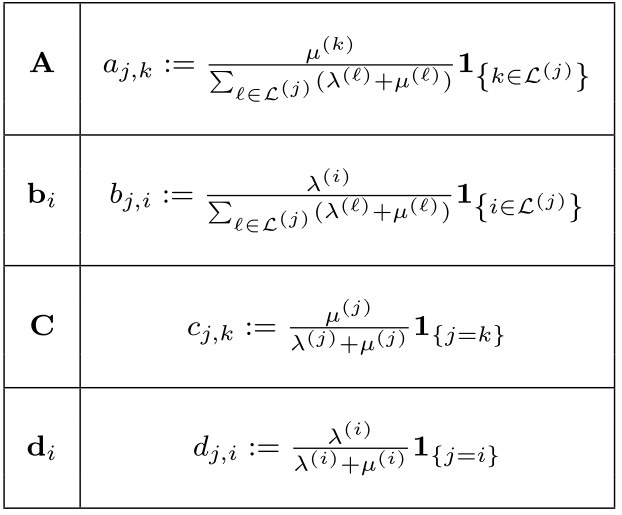

In [10]:
def calcul_A(F, lambda_, mu):
    N = len(F)
    A = np.zeros((N, N))
    for j in range(N):
        denom = sum(lambda_[k] + mu[k] for k in np.where(F[j] == 1)[0])
        for k in np.where(F[j] == 1)[0]:
            if denom > 0:
                A[j, k] = mu[k] / denom
    return A

def calcul_bi(F, lambda_, mu, i):
    N = len(F)
    b = np.zeros(N)
    for j in range(N):
        denom = sum(lambda_[k] + mu[k] for k in np.where(F[j] == 1)[0])
        if i in np.where(F[j] == 1)[0] and denom > 0:
            b[j] = lambda_[i] / denom
    return b

In [11]:
#On met les vecteurs b_i en colonnedans une matrice B
def calcul_B(F, lambda_, mu):
  N = len(F)
  B=np.zeros((N,N))
  for j in range(N):
    B[:,j] = calcul_bi(F, lambda_, mu, j)
  return B

Vérifions que C= disque de rayon spectral et de centre 0 est un fermé borné.

In [12]:
'''Valeurs propres et rayon spectral de A'''
A = calcul_A(F,lambdas,mus)
vp_A = np.linalg.eigvals(A)
rho = max(abs(vp_A))
print(rho)

0.34886894378747196


##Étude de la matrice I-A
Nous allons inverser la matrice I-A afin de l'inverser pour résoudre le système **(I-A)pi=bi**.

In [13]:
'''Construction de I-A'''
A = calcul_A(F,lambdas,mus)
I = np.eye(A.shape[0])
Z = I - A

vp_A = np.linalg.eigvals(A)
rho_A = max(abs(vp_A))
print(rho_A)

0.34886894378747196


In [14]:
'''Valeurs propres et Rayon spectral de I-A'''
vp_Z = np.linalg.eigvals(Z)
rho = max(abs(vp_Z))
print(rho)

1.1161081601914415


In [15]:
#On vérifie que rho(I-A) < norme(A)
print(np.linalg.norm(Z))

3.2517329620753217


In [16]:
'''Inverse de la matrice I-A'''
Z_inv = np.linalg.inv(Z)

In [17]:
B = calcul_B(F, lambdas, mus)
P = Z_inv @ B
print(P)
#On récupère les vecteurs p_i en colonne dans une matrice P


[[0.07912922 0.18028324 0.07887983 0.08124909 0.25584999 0.01612817
  0.0372368  0.10787548 0.         0.14298028]
 [0.19939014 0.01156158 0.00462317 0.17510016 0.03463176 0.01462873
  0.09195085 0.07174125 0.         0.37787995]
 [0.03783653 0.016437   0.0008773  0.08746899 0.28761963 0.01783742
  0.01998452 0.37604097 0.         0.13334905]
 [0.07378113 0.01045633 0.00171073 0.03410137 0.1347239  0.09036464
  0.09280494 0.07708369 0.         0.37074182]
 [0.16333011 0.07995467 0.00378706 0.15744965 0.02998437 0.06722266
  0.07740103 0.15846804 0.         0.17742513]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.22376647 0.01213104 0.00518837 0.05203935 0.02221164 0.00481191
  0.00628296 0.23797859 0.         0.42950685]
 [0.02932629 0.00329555 0.00067997 0.29878213 0.03656795 0.02408427
  0.02479361 0.03082339 0.         0.5212015 ]
 [0.01517496 0.00298919 0.05818908 0.04997552 0.04425647 0.09981212
  0.00593544 0.23855

In [18]:

def calcul_D(lambda_,mu):
  N=len(lambda_)
  D = np.zeros((N,N))
  for i in range(N):
    for j in range(N):
      if i==j:
        D[i,j]=lambda_[i]/(lambda_[i]+mu[i])
  return D

#print(calcul_D(lambdas,mus))


In [19]:
def calcul_C(lambda_,mu):
  N=len(lambda_)
  C = np.zeros((N,N))
  for i in range(N):
    for j in range(N):
      if i==j:
        C[i,j]=mu[i]/(lambda_[i]+mu[i])
  return C

#print(calcul_C(lambdas,mus))


In [20]:
C = calcul_C(lambdas,mus)
D = calcul_D(lambdas,mus)
Q = C @ P + D
print(Q)
#Q contient en colonnes les vecteurs qi

[[7.86975428e-01 4.17048315e-02 1.82472304e-02 1.87953120e-02
  5.91856501e-02 3.73092205e-03 8.61396914e-03 2.49547797e-02
  0.00000000e+00 3.30755566e-02]
 [1.20547147e-01 4.02410605e-01 2.79507020e-03 1.05861929e-01
  2.09376447e-02 8.84422740e-03 5.55915808e-02 4.33732711e-02
  0.00000000e+00 2.28458389e-01]
 [2.65518872e-02 1.15347130e-02 2.98862903e-01 6.13816040e-02
  2.01837865e-01 1.25174614e-02 1.40241890e-02 2.63887783e-01
  0.00000000e+00 9.35780612e-02]
 [3.53322665e-02 5.00732314e-03 8.19232705e-04 5.37451019e-01
  6.45165046e-02 4.32737650e-02 4.44423782e-02 3.69137922e-02
  0.00000000e+00 1.77540628e-01]
 [6.83620343e-02 3.34651321e-02 1.58507845e-03 6.59007600e-02
  5.93998670e-01 2.81361340e-02 3.23963029e-02 6.63270082e-02
  0.00000000e+00 7.42615225e-02]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 4.41673339e-01 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [1.65184320e-01 8.95512790e-03 3.83005141e-03 3.84154302e

In [21]:
def solve_pi(A, b):
    I = np.eye(len(A))
    try:
        return np.linalg.solve(I - A, b)
    except np.linalg.LinAlgError as e:
        print("Matrix solve failed:", e)
        return None

In [22]:
def calcul_bi(F, lambdas, mus, i):
    n = F.shape[0]
    bi = np.zeros(n)
    for j in range(n):
        if F[i, j] == 1:
            bi[j] += lambdas[i]
        if F[j, i] == 1:
            bi[j] -= mus[i]
    return bi



##Optimisation avec les polynômes de Faber de seconde espèce


In [23]:
def faber_2nd_espèce(A, b, m, a, b_):
    """

    Paramètres:
    - A: matrice (spectre supposé dans K = [a, b_])
    - b: vecteur initial
    - m: degrée d'approximation

    """
    n = len(b)
    I = np.eye(n) #matrice identité
    x = b.copy()
    r = b.copy()

    C = (2 * A - (a + b_) * I) / (b_ - a)
    beta_k = lambda k: 1 / (1 + k)

    for k in range(1, m + 1):
        r = C @ r
        x += beta_k(k) * r

    return x

def psi_score_faber2(F, lambdas, mus, m=30, a=0, b=1):
    """

    Paramètres:
    - F: matrice d'adjacence (n x n)
    - lambdas: tableau contenant les lambdas
    - mus: tableau contenant les mus
    - m: degrée d'approximation

    """
    n = F.shape[0]
    A = F / np.maximum(F.sum(axis=1, keepdims=True), 1)
    psi_scores = []

    for i in range(n):
        b_i = np.zeros(n)
        for j in range(n):
            if F[i, j] == 1:
                b_i[j] += lambdas[i]
            if F[j, i] == 1:
                b_i[j] -= mus[i]

        p_i = faber_2nd_espèce(A, b_i, m, a=a, b_=b)
        psi_scores.append(np.linalg.norm(p_i, 1))  # norme L1

    return np.array(psi_scores)
psi_scores = psi_score_faber2(F, lambdas, mus, m=3, a = -rho_A, b = rho_A)
print(psi_scores)

[ 5.52729919  6.70089412  1.4866915   2.80672497 18.00202978 10.90349056
 16.77490161  5.13351835 10.30951967 33.03727137]


On remarque que plus on augmente le degré d'approximation, plus les psi-score de chaque noeud grandissent.

In [42]:
def richardson(A, B, m):
  n = A.shape[0]
  x = np.random.rand(n,n)
  print(x.shape)
  for i in range(m):
    x = A @ x + B
  return x

x = richardson(A, B, 100)
print(x.shape)
print(P[0])
print(x[0])

(10, 10)
(10, 10)
[0.07912922 0.18028324 0.07887983 0.08124909 0.25584999 0.01612817
 0.0372368  0.10787548 0.         0.14298028]
[7.91292211e-02 1.80283242e-01 7.88798265e-02 8.12490943e-02
 2.55849994e-01 1.61281727e-02 3.72367957e-02 1.07875477e-01
 1.98225327e-46 1.42980283e-01]


##Visualisation des valeurs propres

In [25]:
eigvals = np.linalg.eigvals(A)
print(eigvals)

[ 0.00000000e+00+0.j          3.48868944e-01+0.j
 -1.04740981e-01+0.15888609j -1.04740981e-01-0.15888609j
 -9.00835487e-02+0.j          3.98393717e-03+0.j
 -3.89791946e-16+0.j         -2.66436849e-02+0.13089037j
 -2.66436849e-02-0.13089037j  0.00000000e+00+0.j        ]


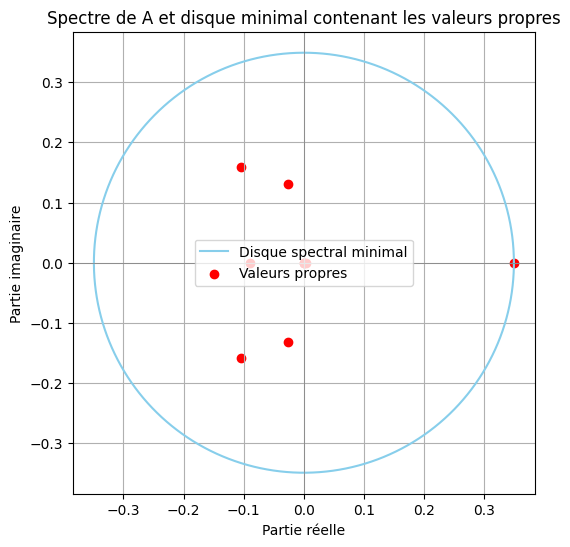

In [26]:
def plot_spectrum_and_optimal_disk(A):
    """
    Affiche les valeurs propres d'une matrice A dans le plan complexe,
    ainsi que le plus petit disque centré sur le barycentre spectral contenant toutes les valeurs propres.
    """
    eigvals = np.linalg.eigvals(A)
    real_parts = eigvals.real
    imag_parts = eigvals.imag

    center = np.mean(eigvals)
    radius = max(abs(eigvals - center))

    theta = np.linspace(0, 2 * np.pi, 400)
    circle_x = center.real + radius * np.cos(theta)
    circle_y = center.imag + radius * np.sin(theta)

    plt.figure(figsize=(6, 6))
    plt.plot(circle_x, circle_y, label='Disque spectral minimal', color='skyblue')
    plt.scatter(real_parts, imag_parts, color='red', label='Valeurs propres')
    plt.axhline(0, color='gray', lw=0.5)
    plt.axvline(0, color='gray', lw=0.5)
    plt.gca().set_aspect('equal', adjustable='box')
    plt.title("Spectre de A et disque minimal contenant les valeurs propres")
    plt.xlabel("Partie réelle")
    plt.ylabel("Partie imaginaire")
    plt.legend()
    plt.grid(True)
    plt.show()

A = calcul_A(F,lambdas,mus)
plot_spectrum_and_optimal_disk(A)


In [27]:
#Ne marche pas à cause d'un problème d'installation de solveur
def find_optimal_circle(eigenvalues):
    n = len(eigenvalues)
    R = cp.Variable(nonneg=True)
    x_c = cp.Variable()
    y_c = cp.Variable()

    constraints = []
    for i in range(n):
        l_real = eigenvalues[i].real
        l_imag = eigenvalues[i].imag
        # Correction : créer un vecteur avec les différences
        diff = cp.vstack([l_real - x_c, l_imag - y_c])
        constraints.append(cp.norm(diff, 2) <= R)

    problem = cp.Problem(cp.Minimize(R), constraints)
    problem.solve(solver='ECOS')

    if problem.status != 'optimal':
        raise ValueError("Le problème n'a pas convergé vers une solution optimale.")

    return R.value, x_c.value, y_c.value

R, x_c, y_c = find_optimal_circle(eigvals)
print(R, x_c, y_c)

0.25463150140740604 0.0942374407783219 0.0


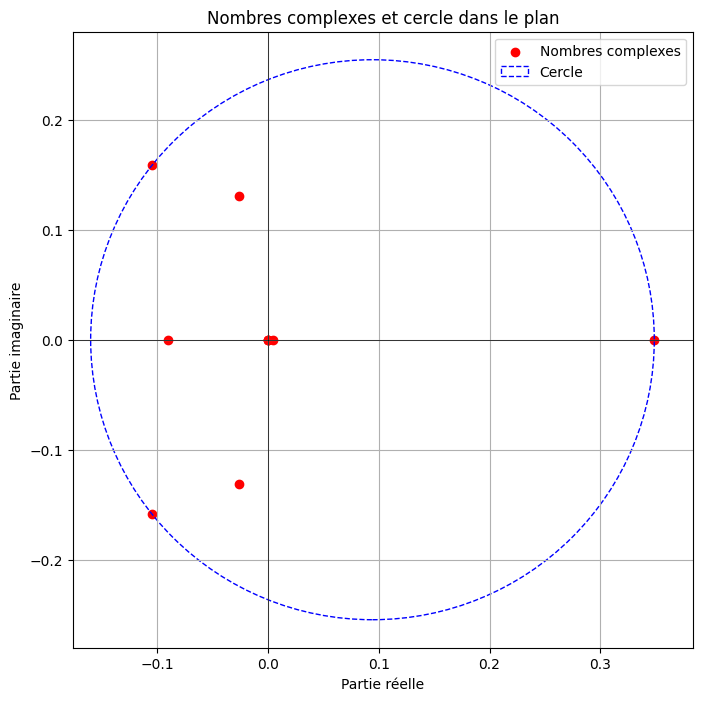

In [29]:


# Extraire parties réelles et imaginaires des nombres complexes
x = [z.real for z in eigvals]
y = [z.imag for z in eigvals]

# Créer la figure
plt.figure(figsize=(8, 8))
plt.grid(True)
plt.axhline(0, color='black', linewidth=0.5)
plt.axvline(0, color='black', linewidth=0.5)
plt.xlabel('Partie réelle')
plt.ylabel('Partie imaginaire')
plt.title('Nombres complexes et cercle dans le plan')

# Tracer les points
plt.scatter(x, y, color='red', label='Nombres complexes')

# Tracer le cercle
cercle = plt.Circle((x_c, y_c), R, fill=False, color='blue', linestyle='--', label='Cercle')
plt.gca().add_patch(cercle)

# Ajuster les limites des axes pour bien voir le cercle
plt.xlim((x_c - R)*1.1, (x_c + R) * 1.1)
plt.ylim((y_c - R)*1.1, (y_c + R)*1.1)

# Afficher la légende
plt.legend()

# Afficher le graphique
plt.show()

In [38]:
n = A.shape[0]
x_n = np.random.rand(n)
x_n1 = A @ x_n + B
print(B.shape)

(10, 10)


In [ ]:
def richardson_counted(A, B, e):
  i = 0
  n = A.shape[0]
  x_n = np.random.rand(n,n)
  x_n1 = A @ x_n + B
  while(np.linalg.norm(x_n - x_n1) > e):
    i+=1
    x_n = x_n1
    x_n1 = A @ x_n + B
    
  return x_n1, i

x, i = richardson_counted(A,B,1e-7)
print(x[0])
print(P[0])
print(i)


[7.91292212e-02 1.80283242e-01 7.88798266e-02 8.12490944e-02
 2.55849995e-01 1.61281728e-02 3.72367958e-02 1.07875477e-01
 1.15509072e-10 1.42980283e-01]
[0.07912922 0.18028324 0.07887983 0.08124909 0.25584999 0.01612817
 0.0372368  0.10787548 0.         0.14298028]
21
